In [1]:
import pandas as pd
import nltk
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import hf_xet

c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('debate_transcripts_cleaned.csv', 'r') as f:
    df_transcripts = pd.read_csv(f)

## Vader Analysis

In [3]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def text_preprocess(text):
    # Tokenize text
    wtokens = word_tokenize(text)

    # Filtering tokens
    t_filtered = [t.lower() for t in wtokens if t.lower() not in stop_words and t.isalpha()]

    # Lemmatization
    t_lemmatized = [lem.lemmatize(t) for t in t_filtered]

    return " ".join(t_lemmatized)

# Apply preprocessing to the 'dialogue' column
df_cleaned_text = df_transcripts.copy()
df_cleaned_text["cleaned_text"] = df_transcripts['dialogue'].apply(text_preprocess)

# Display the first 15 entries of original and cleaned columns
df_cleaned_text[['dialogue', 'cleaned_text']].head(15)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,dialogue,cleaned_text
0,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith nixon election abraham lincoln said ques...
1,And now the opening statement by Vice Presiden...,opening statement vice president richard nixon
2,"Mr. Smith, Senator Kennedy. The things that Se...",smith senator kennedy thing senator kennedy sa...
3,"Thank you, Mr. Nixon. That completes the openi...",thank nixon completes opening statement candid...
4,"Senator, the Vice President in his campaign ha...",senator vice president campaign said naive tim...
5,"Well, the Vice President and I came to the Con...",well vice president came congress together ser...
6,"Mr. Nixon, would you like to comment on that s...",nixon would like comment statement
7,I have no comment.,comment
8,The next question: Mr. Novins.,next question novins
9,"Mr. Vice President, your campaign stresses the...",vice president campaign stress value eight yea...


In [4]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
def analyze_vader(text):
    scores = vader.polarity_scores(text)
    return scores['compound']  # Main sentiment score [-1, 1]

def add_vader_sentiment(df, text_column='dialogue'):
    df['vader_sentiment'] = df[text_column].apply(text_preprocess).apply(analyze_vader)
    return df

add_vader_sentiment(df_transcripts, 'dialogue')

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_sentiment
0,1960,1960-09-26,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,0.9995
1,1960,1960-09-26,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,0.0000
2,1960,1960-09-26,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,0.9982
3,1960,1960-09-26,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,0.3612
4,1960,1960-09-26,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,-0.2732
...,...,...,...,...,...,...,...,...,...,...
9928,2024,2024-10-01,Walz,"Well, thank you, Senator Vance. Thank you to C...",True,Democratic,False,True,False,0.9959
9929,2024,2024-10-01,Brennan,"Governor Walz. Thank you. Senator Vance, your ...",False,NaN,False,True,False,0.3612
9930,2024,2024-10-01,Vance,"Well, I want to thank Governor Walz, you folks...",True,Republican,True,True,False,0.9950
9931,2024,2024-10-01,Brennan,"Senator Vance, thank you. And thank you both f...",False,NaN,False,True,False,0.6124


## BERT

In [19]:
from transformers import pipeline

# Load sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Test texts
examples = [
    "I love democracy.",
    "I hate this country.",
    "Hmmm, I don't know about that.",
]

# Run the pipeline and print label outputs
for text in examples:
    result = sentiment_pipeline(text)[0]
    print(f"Text: {text}")
    print(f"Label: {result['label']} | Score: {result['score']:.4f}\n")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Text: I love democracy.
Label: positive | Score: 0.9530

Text: I hate this country.
Label: negative | Score: 0.9313

Text: Hmmm, I don't know about that.
Label: neutral | Score: 0.7509



In [20]:
# Load pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Scoring function
def analyze_bert(text):
    try:
        result = sentiment_pipeline(text)[0]
        label = result['label']
        score = result['score']  # Confidence

        if label == 'positive':  # Positive
            return score
        elif label == 'negative':  # Negative
            return -score
        else:  # Neutral
            return 0.0
    except:
        return 0.0

# Add to DataFrame
def add_bert_sentiment(df, text_column='dialogue'):
    df['bert_sentiment'] = df[text_column].apply(analyze_bert)
    return df


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


## Comparison Values

In [23]:
def add_diff_sentiment(df, text_column='dialogue'):
    df = add_vader_sentiment(df, text_column)
    df = add_bert_sentiment(df, text_column)
    df['diff_sentiment'] = df['vader_sentiment'] - df['bert_sentiment']
    return df

## First Test

In [24]:
df_sentiment = add_diff_sentiment(df_transcripts, text_column='dialogue')
df_sentiment.to_csv('debate_transcripts_sentiment.csv', index=False)

In [25]:
df_sentiment.head()

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_sentiment,bert_sentiment,diff_sentiment
0,1960,1960-09-26,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,0.9995,0.000000,0.999500
1,1960,1960-09-26,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,0.0000,0.000000,0.000000
2,1960,1960-09-26,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,0.9982,0.000000,0.998200
3,1960,1960-09-26,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,0.3612,0.561918,-0.200718
4,1960,1960-09-26,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,-0.2732,-0.626539,0.353339


In [33]:
df_vader = df_sentiment[(df_sentiment["is_candidate"]) & (~df_sentiment["VP_debate"])]

In [34]:
df_vader.sort_values(by='diff_sentiment', ascending=False)

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_sentiment,bert_sentiment,diff_sentiment
6723,2016,2016-09-26,Trump,"And she doesnt say that, because shes got no b...",True,Republican,True,False,False,0.9601,-0.847617,1.807717
9730,2024,2024-09-10,Trump,Obamacare was lousy health care. Always was. I...,True,Republican,True,False,False,0.9634,-0.824582,1.787982
4321,2008,2008-09-26,Mccain,"Well, the first thing we have to do is get spe...",True,Republican,False,False,False,0.9182,-0.849954,1.768154
4523,2008,2008-09-26,Mccain,"Well, the first thing we have to do is get spe...",True,Republican,False,False,False,0.9182,-0.849954,1.768154
5137,2008,2008-10-15,Mccain,"Well, it is a terribly painful situation for A...",True,Republican,False,False,False,0.9854,-0.775379,1.760779
...,...,...,...,...,...,...,...,...,...,...,...,...
5021,2008,2008-10-15,Mccain,"Well, let let me say, Bob, thank you. And tha...",True,Republican,False,False,False,-0.8176,0.867880,-1.685480
4587,2008,2008-09-26,Obama,"Look, Im very proud of my vice presidential se...",True,Democratic,True,False,False,-0.9038,0.818572,-1.722372
4385,2008,2008-09-26,Obama,"Look, Im very proud of my vice presidential se...",True,Democratic,True,False,False,-0.9038,0.818572,-1.722372
1748,1992,1992-10-11,Perot,"Well, its been a privilege to be able to talk ...",True,Independent,False,False,False,-0.8657,0.893304,-1.759004


In [28]:
df_transcripts.describe(include='all')

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_sentiment,bert_sentiment,diff_sentiment
count,9933.000000,9933,9933,9933,9933,5629,9933,9933,9933,9933.000000,9933.000000,9933.000000
unique,NaN,48,171,8563,2,3,2,2,2,NaN,NaN,NaN
top,NaN,2020-09-29,Trump,(CROSSTALK),True,Republican,False,False,False,NaN,NaN,NaN
freq,NaN,858,930,163,5629,2990,7187,7334,8332,NaN,NaN,NaN
mean,2004.906876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198697,-0.063147,0.261844
std,14.783792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.493670,0.417083,0.526421
min,1960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.996700,-0.959173,-1.836686
25%,1992.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.073990
75%,2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.563700,0.000000,0.612400


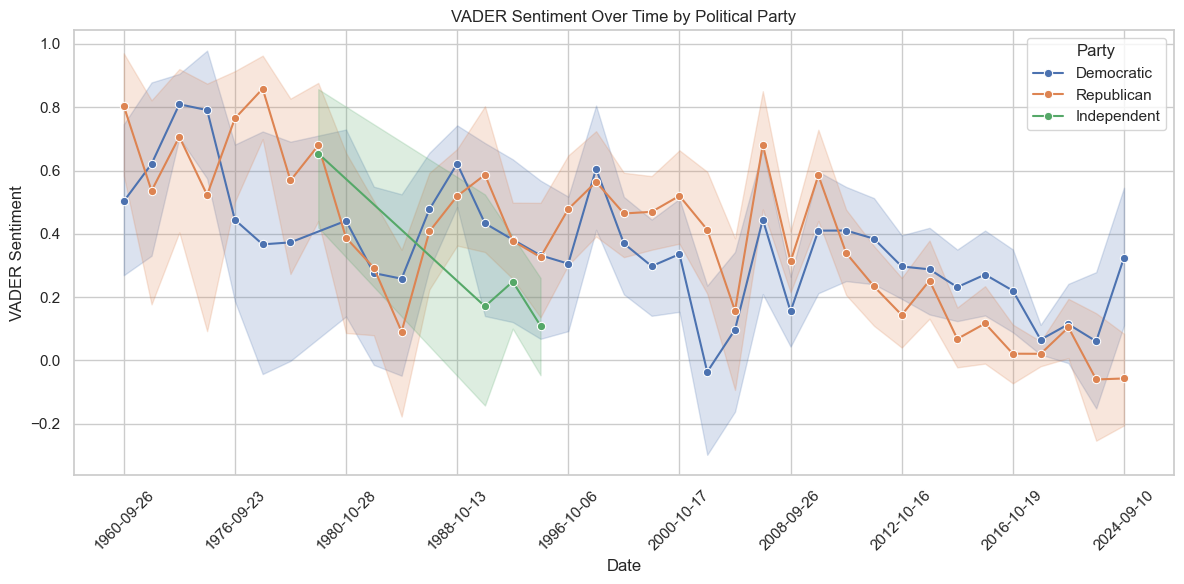

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_vader, x='date', y='vader_sentiment', hue='party', marker='o')

# Set title and labels
plt.title('VADER Sentiment Over Time by Political Party')
plt.xlabel('Date')
plt.ylabel('VADER Sentiment')
plt.legend(title='Party')

# Modify x-axis ticks to show only every 4th label
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::4])
ax.set_xticklabels([label.get_text() for label in xticklabels[::4]], rotation=45)

plt.tight_layout()
plt.show()

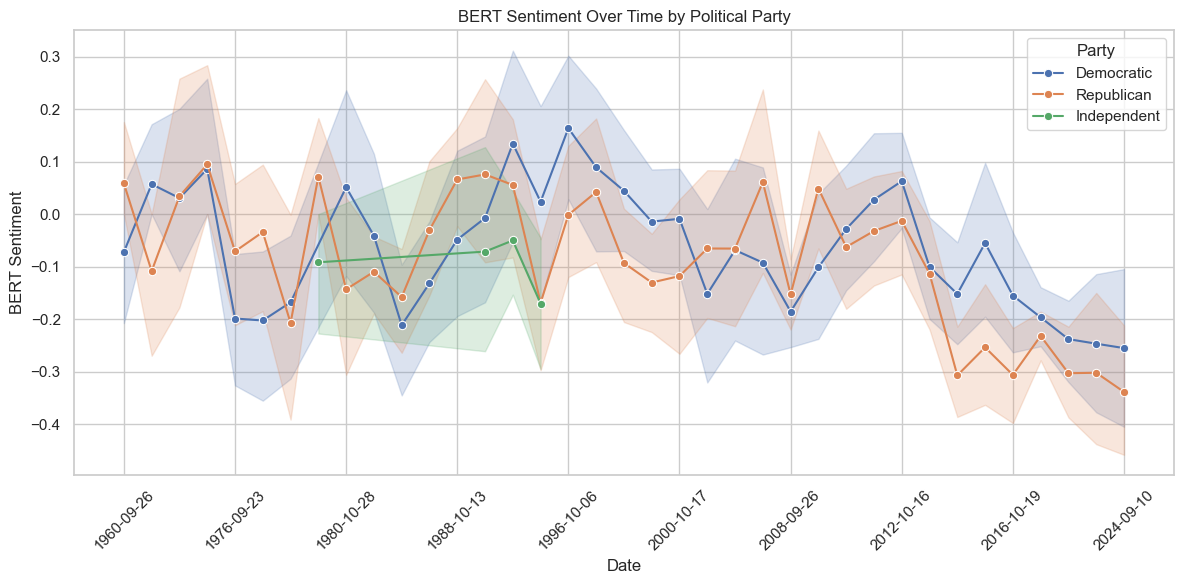

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_vader, x='date', y='bert_sentiment', hue='party', marker='o')

# Set title and labels
plt.title('BERT Sentiment Over Time by Political Party')
plt.xlabel('Date')
plt.ylabel('BERT Sentiment')
plt.legend(title='Party')

# Modify x-axis ticks to show only every 4th label
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::4])
ax.set_xticklabels([label.get_text() for label in xticklabels[::4]], rotation=45)

plt.tight_layout()
plt.show()

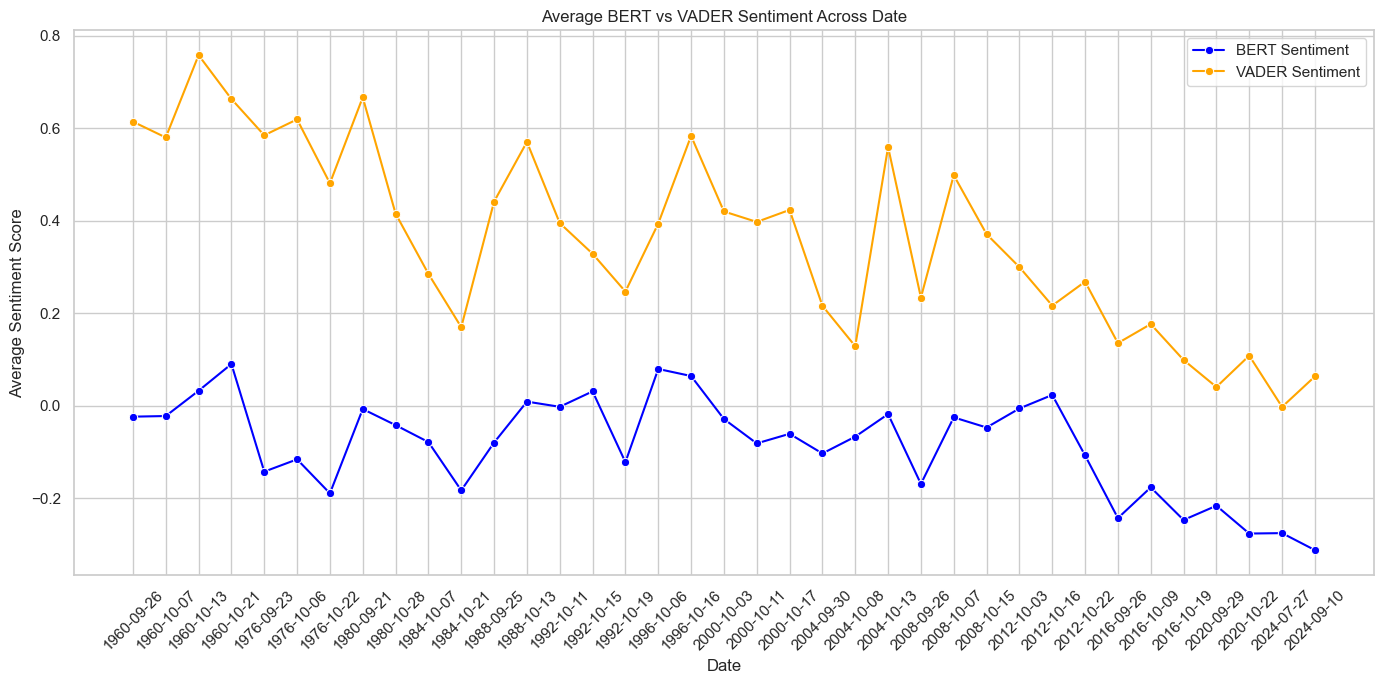

In [31]:
plt.figure(figsize=(14, 7))

# Calculate average sentiment per date
avg_sentiment = df_vader.groupby('date')[['bert_sentiment', 'vader_sentiment']].mean().reset_index()

sns.lineplot(
    data=avg_sentiment,
    x='date',
    y='bert_sentiment',
    label='BERT Sentiment',
    color='blue',
    marker='o'
)
sns.lineplot(
    data=avg_sentiment,
    x='date',
    y='vader_sentiment',
    label='VADER Sentiment',
    color='orange',
    marker='o'
)

plt.title('Average BERT vs VADER Sentiment Across Date')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

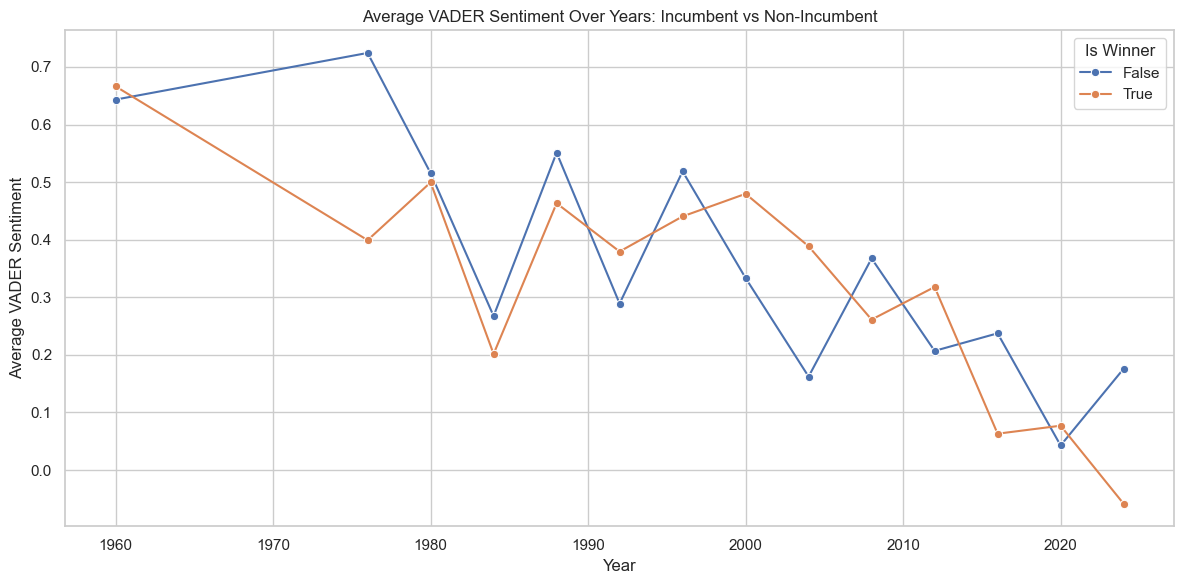

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group by year and incumbent status
avg_sentiment_by_year_incumbent = (
    df_vader.groupby(['year', 'is_winner'])['vader_sentiment']
    .mean()
    .reset_index()
)

# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_sentiment_by_year_incumbent,
    x='year',
    y='vader_sentiment',
    hue='is_winner',
    marker='o'
)

# Add labels and title
plt.title('Average VADER Sentiment Over Years: Incumbent vs Non-Incumbent')
plt.xlabel('Year')
plt.ylabel('Average VADER Sentiment')
plt.legend(title='Is Winner')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_3140\3921246671.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


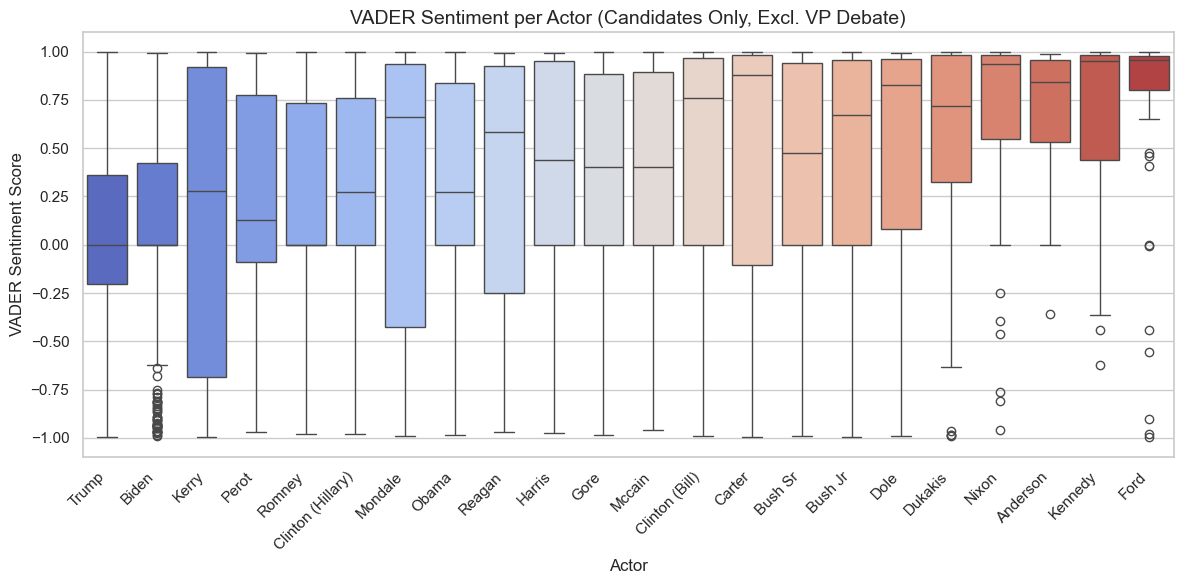

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate mean sentiment per actor for ordering
mean_sentiment = df_vader.groupby('actor')['vader_sentiment'].mean().sort_values()

# Set the order of actors based on mean sentiment
actor_order = mean_sentiment.index

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the box plot
sns.boxplot(
    data=df_vader,
    x='actor',
    y='vader_sentiment',
    order=actor_order,
    palette='coolwarm'
)

# Customize the plot
plt.title('VADER Sentiment per Actor (Candidates Only, Excl. VP Debate)', fontsize=14)
plt.xlabel('Actor', fontsize=12)
plt.ylabel('VADER Sentiment Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
